<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note:To Checkin

In [21]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 119 (delta 47), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (119/119), 1.80 MiB | 2.45 MiB/s, done.
Resolving deltas: 100% (47/47), done.
ldpc_ber_18_11.png  project  sample_data
MainModel.ipynb		    MainModelOneHotMethod.ipynb		  README.md
MainModelKeras.ipynb	    MainModelOneHotMethodSoftMax.ipynb	  util.py
MainModelKerasOneHot.ipynb  MainModelWithSingleBERTraining.ipynb


In [22]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [23]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [24]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [25]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 1 1 ... 0 1 1]
 [1 1 1 ... 0 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [1 0 1 ... 1 0 0]
 [0 1 1 ... 0 1 0]
 [1 1 0 ... 0 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [26]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.59s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.24s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.65s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.20s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 15.68s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.30s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.66s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.88s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.29s
SNR: 0.500:
 -> BER: 0.56
 -> Total Time: 13.12s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.14s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.33s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.52s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.55s
SNR: 1.000:
 -> BER: 0.53
 -> Total Time: 11.53s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.76s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.61s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [27]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.30s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.71s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 3.99s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.37s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 13.37s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.36s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.34s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.57s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.74s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 12.00s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.85s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.78s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.63s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.51s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 8.77s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.73s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.45s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [28]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.45s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.86s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.16s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.54s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 14.01s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.18s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.28s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.47s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.61s
SNR: 0.500:
 -> BER: 0.56
 -> Total Time: 11.54s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.97s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.88s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.72s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 9.58s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.63s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.36s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

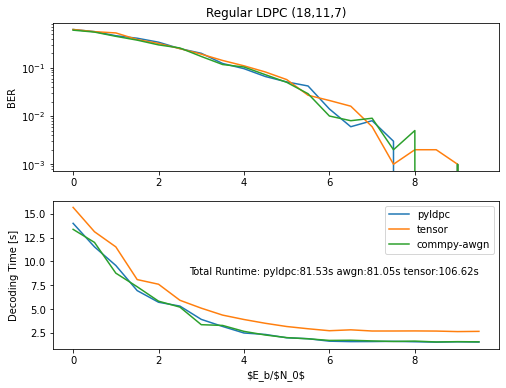

In [29]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [30]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras import Model
from keras.layers.normalization import BatchNormalization


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()
decoder_input_x = tf.placeholder("float32", [None, input_message_length], name="decoder_input_x")

snr_std = 7.0

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer1 = Dense(CHANEL_SIZE, activation='tanh')(input_message_x)
#enc_layer2 = Dense(CHANEL_SIZE, activation='sigmoid')(enc_layer1)
enc_layer2=enc_layer1
#encoded2 = Dense(CHANEL_SIZE, activation='sigmoid')(encoded1)
# this model maps an input to its encoded representation
#enc_layer2 = BatchNormalization() (enc_layer2)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
#enc_layer2 = tf.round(enc_layer1)
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(CHANEL_SIZE,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(CHANEL_SIZE,))
# "decoded" is the lossy reconstruction of the input
dec_layer1 = Dense(CHANEL_SIZE, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation='sigmoid')(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

decoder_output = (tf.nn.sigmoid(decoder_input_x))


In [31]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "functional_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 18)           216         input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Square_1 (TensorFlo multiple             0           dense_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Mean_1 (TensorFlowO multiple             0           tf_op_layer_Square_1[0][0]       
______________________________________________________________________________________

In [32]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))
test_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (test_input_message)
print (len(test_input_message))

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 [0 0 1 ... 0 1 1]]
10000
[[0 1 0 ... 1 0 0]
 [0 1 0 ... 1 0 0]
 [0 1 1 ... 0 1 0]
 ...
 [1 1 1 ... 0 1 1]
 [0 0 1 ... 0 1 0]
 [1 0 1 ... 1 1 1]]
10000


In [33]:
import keras

#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  opt = keras.optimizers.Adam(learning_rate=0.003)
  autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=20,
                batch_size=500,
                shuffle=False,
                validation_data=(test_input_message, test_input_message))
  
  

Training for SNR= 0.0  sigma= 1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 0s 37us/sample - loss: 0.7091 - val_loss: 0.6055
Epoch 2/20
10000/10000 [==============================] - 0s 8us/sample - loss: 0.6109 - val_loss: 0.4960
Epoch 3/20
10000/10000 [==============================] - 0s 7us/sample - loss: 0.5232 - val_loss: 0.4132
Epoch 4/20
10000/10000 [==============================] - 0s 7us/sample - loss: 0.4678 - val_loss: 0.3539
Epoch 5/20
10000/10000 [==============================] - 0s 7us/sample - loss: 0.4317 - val_loss: 0.3071
Epoch 6/20
10000/10000 [==============================] - 0s 7us/sample - loss: 0.4048 - val_loss: 0.2703
Epoch 7/20
10000/10000 [==============================] - 0s 7us/sample - loss: 0.3814 - val_loss: 0.2394
Epoch 8/20
10000/10000 [==============================] - 0s 7us/sample - loss: 0.3638 - val_loss: 0.2128
Epoch 9/20
10000/10000 [==============================] - 0s 7us/sa

In [34]:
awgn_channel = GaussianNoise(Snr2Sigma(10),input_shape=(CHANEL_SIZE,))
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
opt = keras.optimizers.Adam(learning_rate=0.003)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
autoencoder.evaluate(input_message, input_message, batch_size=128)


7.71153951791348e-06

In [35]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(CHANEL_SIZE,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
  #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,CHANEL_SIZE])
    #noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,CHANEL_SIZE])
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 2.82s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.56s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.31s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.05s
SNR: 0.000:
 -> BER: 0.69
 -> Total Time: 15.75s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.76s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 2.26s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 3.00s
SNR: 0.500:
 -> BER: 0.65
 -> Total Time: 7.53s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.74s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.50s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.25s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.99s
SNR: 1.000:
 -> BER: 0.57
 -> Total Time: 7.48s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.74s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.49s
SNR: 1.500 - Iter: 750 - Last 250.0 iter

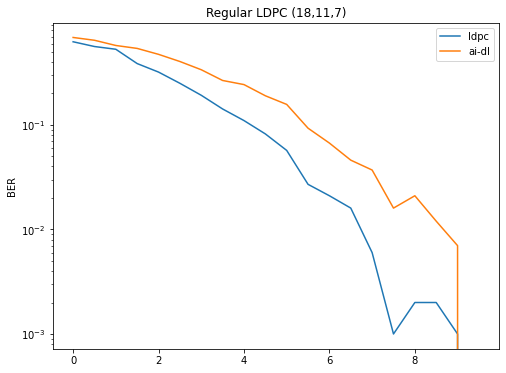

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [37]:
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 [0 0 1 ... 0 1 1]]
10000


In [38]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(CHANEL_SIZE,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
  #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    #noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,CHANEL_SIZE])
    noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,CHANEL_SIZE])
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.66s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.33s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.99s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.65s
SNR: 0.000:
 -> BER: 0.68
 -> Total Time: 6.64s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.66s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.98s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.64s
SNR: 0.500:
 -> BER: 0.67
 -> Total Time: 6.61s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.65s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.31s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.97s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.62s
SNR: 1.000:
 -> BER: 0.59
 -> Total Time: 6.55s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.65s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.31s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

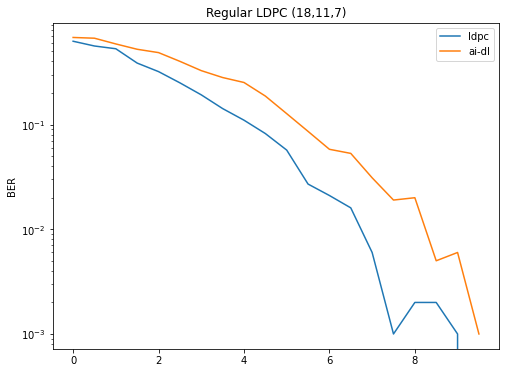

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()